
# CS 171 / EE 142 Problem Set 3
# Due Friday, March 1, 2024

<div style="color: #000000;background-color: #FFEEFF">
In this problem set, you are to implement a three-layer (3 layers of weights, 2 hidden layers of units) neural network for binary classification.  All non-linearities are to be hyperbolic tangents (tanh).

Details are given below.  *Please read the **entire** notebook carefully before proceeding.*

You need to both fill in the necesary code, **and** answer the question at the bottom.</div>

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): Shivam<br>
Your student ID (submitter): X717670
    
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
</div>

<div class="alert alert-success">
    <font size=+2>Total Problem Set Grading</font> (to be completed by grader)<br>
    Total Points: /20<br>
    Late Days Used on this Assignment: <br>
    Total Late Days Used: <br>
</div>

In [3]:
# Below are the only imports that are necessary (or allowed)
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import time
from IPython import display

## Data

<div style="color: #000000;background-color: #FFEEFF">
We will be using a USPS digit dataset (provided in the file uspsall73.mat).
It has 16-by-16 grayscale images of each of the 10 different hand-written digits
However, we will load only two of the digits to use as the two classes in
binary classification (the sevens and the nines).  The code below already z-score 
normalizes the data for you -- an important first step!
<p>
    <p>
    Note:  digit recognition typically uses larger datasets (more than 1000 images per class) and often with higher resolution images.  We are using lower resolution images (fewer features) and small training and validation data sets (fewer examples) to speed up training time.  You may choose to further reduce the training data set during your own debugging to speed things up.  Be sure to remove that reduction and rerun the notebook with the full dataset once you have finished debugging.
</div>

In [4]:
# function to load two of the 10 classes (c1 is for Y=-1 and c2 is for Y=+1)
def loaddigitdata(c1,c2,m):
    f = h5py.File('/usr/local/cs171/uspsall73.mat','r') 
    data = f.get('data') 
    data = np.array(data).astype(float)
    X = np.concatenate((data[c1,:,:],data[c2,:,:]))
    Y = np.concatenate((-np.ones((data.shape[1])),np.ones((data.shape[1]))))
    
    rs = np.random.RandomState(seed=132857) # setting seed so that dataset is consistent
    p = rs.permutation(X.shape[0])
    X = X[p] # this and next line make copies, but that's okay given how small our dataset is
    Y = Y[p]
    
    trainX = X[0:m,:] # use the first m (after shuffling) for training
    trainY = Y[0:m,np.newaxis]
    validX = X[m:,:] # use the rest for validation
    validY = Y[m:,np.newaxis]
    return (trainX,trainY,validX,validY)

# In case you care (not necessary for the assignment)
def drawexample(x,ax=None): # takes an x *vector* and draws the image it encodes
    if ax is None:
        plt.imshow(np.reshape(x,(16,16)).T,cmap='gist_yarg')
    else:
        ax.imshow(np.reshape(x,(16,16)).T,cmap='gist_yarg')

In [5]:
# load the data, to differentiate between 7s and 9s
# we will use on 1100 examples for training (50% of the data) and the other half for hold-out validation
(trainX,trainY,validX,validY) = loaddigitdata(6,8,1100)
means = trainX.mean(axis=0)
stddevs = trainX.std(axis=0)
stddevs[stddevs<1e-6] = 1.0
trainX = (trainX-means)/stddevs # z-score normalization
validX = (validX-means)/stddevs # apply same transformation to validation set

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 1:</font> <font size=+1>(17 points)</font>
This is the main portion of the assignment.  Read the text below carefully.
</div>

<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /17<br>
</div>

### WRITE `nneval` and `trainneuralnet`

<div style="color: #000000;background-color: #FFFFEE">

Note that the target $Y$ values are +1 and -1.  The internal nodes should all use the hyperbolic tangent (np.tanh) as the nonlinearity.

You need to write the two functions below (plus any more you would like to add to help): `nneval` and `trainneuralnet`.  The first takes an array/matrix of X vectors and the weights from a neural network and returns a vector of discriminant values (should be numbers between -infinity and +infinity).  The second takes a data set (Xs and Ys), the number of hidden units, and the lambda value (for l2-regularization), and returns the weights, Wts.  Wts[0] are the weights from the input to the first hidden layer.  Wts[1] are the weights from the first hidden layer to the second hidden layer.  Wts[2] are the weights from the second hidden layer to the output.

A few notes:
- **Starting Weights**: The code supplied randomly selects the weights near zero.  https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79 has a reasonable explanation of why we are doing it this way.  But for the purposes of the assignment, you can just accept this is a good way to initialize neural network weights.
- **Offset Terms**: Each layer should have an "offset" or "intercept" unit (to supply a 1 to the next layer), except the output layer.
- **Batch Updates**: For a problem this small, use batch updates.  That is, the step is based on the sum of the gradients for each data point in the training set.
- **Step Size**: http://ruder.io/optimizing-gradient-descent/#gradientdescentoptimizationalgorithms describes a number of methods to adaptively control $\eta$ for fast convergence.  You don't need to understand any of them; however, without them, convergence to good solutions on this problem can be quite slow.  Therefore, *use RMSprop*: the code below has a simple version of RMSprop that is sufficient for this assignment.  You need to supply the code that calculates `sumofgrad2` which should be the sum of the square of each element of the *full* gradient (the squared length of the gradient including the regularization term).  (for debugging, feel free to use a constant $\eta$ initially). 
- **Stopping Criterion**: To determine when to stop, check the loss (full loss, including the regularization term) function every 10 iterations.  If it has not improved by at least $10^{-6}$ over those 10 iterations, stop.
- **Regularization**: You should penalize (from the regularization) all of the weights, even those coming out of offset units.  While it makes sense sometimes not to penalize the ones for the constant $1$ units, you'll find this easier if you just penalize them all.

Tips that might help:
- Display the loss function's value every 10 iterations (or so).  It should be getting smaller.  If not, your gradient is not pointing in the right direction.
- The smaller $\lambda$ is and the more units, the more difficult (longer) the optimization will be.
- Write a function to do forward propagation and one to do backward propagation.  Write a function to evaluate the loss function.  In general, break things up to keep things straight.
- Processing the entire batch at once is more efficient in numpy than using a loop over the examples.  Use numpy broadcasting to avoid loops where possible.
- Create a small dataset from the examples in class.  Check that you get the same results for forward propagation.  Check you get the same results for backward propagation.  Check that you get the same results for the gradients.
</div>

In [249]:
### FEEL FREE TO ADD HELPER FUNCTIONS
import cProfile
import random
def addones(Z):
    return np.hstack((np.ones((Z.shape[0],1)),Z))
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def gTrans(z):
    return np.tanh(z)
## Wts is a list (length 3) of the Weight matrices
## X is an m-by-n matrix of m examples
## returns m-length vector of the discriminant, f(x), for each example
def gradTrans(z):
    return 1-np.tanh(z)**2
def delete(arr):
        arr = np.delete(arr,0,axis=1)
        return arr
def nneval(X,Wts):
    ## Your  code here
    #forward propogation
    a_0 = addones(X)
    z_1 = a_0@Wts[0].T  # pre_activation 1
    a_1 = addones(gTrans(z_1)) #applying the transformation and adding intercept term
    z_2 = a_1@Wts[1].T #pre _ activation 2
    a_2 = addones(gTrans(z_2)) # applying the transformation and adding intercep term 
    fx  = a_2@Wts[2].T
    return fx

# Your functions need only work for neural networks of exactly 3 layers of weights
# This training function has a single scalar parameter, nhid, to indicate the number of
# hidden units.  This is the number in the first hidden layer.  The second hidden layer will have 1/2 this number
## X is m-by-n matrix of m examples
## Y is m-length vector of the targets (+1/-1) for each example
## nhid is the number of hidden units in the first hidden layer
## lam is the regularization strength (lambda) ["lambda" is a reserved keyword in Python]
def trainneuralnet(X,Y,nhid,lam):
    # The number of examples (m) and number of input dimensions (n) of the input data
    #To determine when to stop, check the loss (full loss, including the regularization term) 
    #function every 10 iterations. If it has not improved by at least 
    # over those 10 iterations, stop.
    (m,n) = X.shape
    W1 = (np.random.rand(nhid,n+1)*2-1)*np.sqrt(6.0/(n+nhid+1)) # weights to each hidden unit from the inputs (plus the added offset unit)
    W2 = (np.random.rand(nhid//2,nhid+1)*2-1)*np.sqrt(6.0/(nhid+nhid//2+1))
    W3 = (np.random.rand(1,nhid//2+1)*2-1)*np.sqrt(6.0/(nhid//2+2)) # weights to the single output unit from the hidden units (plus the offset unit)
    W1[:,0] = 0 # good initializations for the constant terms
    W2[:,0] = 0 #-nhid/2.0
    W3[:,0] = 0 #-nhid/4.0
    
    Wts = [W1,W2,W3] # I put them together in a list, but you can use a tuple too
    # keep this:!
    Eg2=1
    i=0
    oldloss= float('inf')
    done = False
    while not done:
        # when you need "eta" (the step size), do this after you have already
        # calculated the gradient (but before you take a step):
        # [where "sumofgrad2" is the sum of the squares of each element of the gradient
        #  that is, you square *all* of the gradient values and then add them all together]
        # [recall that this is the gradient of the full loss function that includes every
        #  example *and* the regularizer term]
        a_0 = addones(X)
        z_1 = a_0@Wts[0].T  # pre_activation 1
        a_1 = addones(gTrans(z_1)) #applying the transformation and adding intercept term
        z_2 = a_1@Wts[1].T #pre _ activation 2
        a_2 = addones(gTrans(z_2))
        z_3 = nneval(X,Wts)
        #Derivatives of Activations and Preactivations
        delta_z3 = -(1 - sigmoid(np.multiply(Y,z_3))) * Y
        delta_a2 = delta_z3 @ Wts[2]
        delta_a2 = np.delete(delta_a2,0,axis=1)
        delta_z2 = np.multiply(gradTrans(z_2),delta_a2)
        delta_a1 = delta_z2 @ Wts[1]
        delta_a1 = np.delete(delta_a1,0,axis=1)
        delta_z1 = np.multiply(gradTrans(z_1),delta_a1)
        delta_a0 = delta_z1@Wts[0]
       
        #gradients of each layer + regularization term
        # print("shape of delt_Z1 and a_0",delta_z1.shape,a_0.shape)
        grad_0 = delta_z1.T@a_0 + (2*lam*Wts[0])
        grad_1 = delta_z2.T@a_1 + (2*lam*Wts[1])
        grad_2 = delta_z3.T@a_2 + (2*lam*Wts[2])
        
        #Full LOSS
        Wsquared = np.sum(np.square(Wts[0]))+np.sum(np.square(Wts[1]))+np.sum(np.square(Wts[2]))
        floss= np.sum( -np.log(sigmoid(Y*z_3))) + lam * Wsquared
        sumofgrad2 = np.sum(np.square(grad_0))+np.sum(np.square(grad_1))+np.sum(np.square(grad_2))
        if(i!=0 and i%10==0):
            # print("this is floss",floss)
            if(oldloss-floss<1e-6):
                done= True
            oldloss=floss
        # print(floss)
        Eg2 = 0.9*Eg2 + 0.1*sumofgrad2 
        eta = 0.01/(np.sqrt((1e-10+Eg2)))
        Wts[0]-=  eta*(grad_0)
        Wts[1]-=  eta*(grad_1)
        Wts[2]-=  eta*(grad_2) 
        i+= 1
    print("Number of iterations",i)
    return Wts 
# eX =np.array([[3.49, 0.41],
#     [2.39, 0.34],
#     [3.28, 0.14,],
#     [3.10, 0.31],
#     [3.01, 0.27],
#     [3.11, 0.53],
#     [2.57, 0.53],
#     [3.07, 0.38],
#     [2.54, 0.36],
#     [3.64, 0.05]
# ])
# # eX=eX.T
# W1 = np.array([
#     [0.0, 0.3, -0.5],
#     [0.2, -0.4, -0.7],
#     [-0.5, 0.0, 0.6]
# # ])

# # W(2) matrix
# W2 = np.array([
#     [0.3, -0.6, -0.7, 0.8],
#     [1.0, -1.0, 0.5, 0.4]
# ])

# # W(3) matrix
# W3 = np.array([
#     [-0.7, 1.5, -1.2]
# ])

# # Store the weight matrices in a list
# Wts = [W1, W2, W3]

# Y = np.array([[-1],
#  [-1],
#  [ 1],
#  [ 1],
#  [-1],
#  [ 1],
#  [ 1],
#  [ 1],
#  [-1],
#  [-1]]) 

# fx = nneval(eX,wts)
# print(fx)
# Wts = trainneuralnet(eX,Y,16,1e-5)
# cProfile.run('trainneuralnet()')

In [250]:
%%time
# Use this cell (or others you add) to check your network
# I would debug on simple examples you create yourself (trying to understand what happens with
#  the full 256-dimensional data is hard)
#an example of training on the USPS data with 16/8 hidden units and lambda=0.00001, takes about 1500 iterations and about 4 seconds for the solutions
Wts = trainneuralnet(trainX,trainY,16,1e-5)
# cProfile.run('trainneuralnet(trainX,trainY,16,1e-5)')

Number of iterations 1571
CPU times: user 12.3 s, sys: 34 s, total: 46.3 s
Wall time: 11.6 s


## Performance plot
<div class="alert alert-info">
The code below will plot your algorithm's error rate on this data set for various regularization strengths and numbers of hidden units.

Make sure your code works for this plot.

My code runs in about 10 minutes (to produce the full plot below)
</div>

In [209]:
## Code added to do logistic regression, just for a comparison
def learnlogreg_sklearn(X,Y,regstr=0.0,penalizeb=False):
    X = addones(X)
    Y = Y[:,0]
    from sklearn.linear_model import LogisticRegression as lr
    if regstr==0.0:
        pen = 'none'
        C = np.inf
    else:
        pen = 'l2'
        C = 2.0/regstr # ???

    Y = (Y>0.5).astype(int)
    if penalizeb:
        lrres = lr(tol=1e-6,max_iter=100000,penalty=pen,C=C,
                   fit_intercept=False,
                   solver='newton-cg',multi_class='multinomial').fit(X,Y)
        w = lrres.coef_[0,:]
    else:
        lrres = lr(tol=1e-6,max_iter=100000,penalty=pen,C=C,
                   fit_intercept=True,
                   solver='newton-cg',multi_class='multinomial').fit(X[:,1:],Y)
        w = np.hstack((lrres.intercept_,lrres.coef_[0,:]))
    return w

def predictlogreg(X,w):
    return addones(X)@w

In [210]:
# Code to update the plot as new results are generated
def setupfig():
    f = plt.figure()
    f.set_size_inches(8,8)
    ax = f.add_subplot(111)
    plt.ion()
    f.canvas.draw()
    return (f,ax)

def plotit(lams,nhiddens,erates,f,ax):
    ax.clear()
    for i in range(nhiddens.shape[0]):
        ax.plot(lams,erates[:,i],'*-')
    ax.set_yscale('log',subs=[1,2,3,4,5,6,7,8,9])
    ax.set_yticks([0.1,0.01])
    ax.set_xscale('log')
    f.canvas.draw()
    ax.set_xlabel('lambda')
    ax.set_ylabel('validation error rate')
    ax.legend([(('# hidden units = '+str(x)+','+str(x//2)) if x>0 else 'logistic regression') for x in nhiddens])
    display.display(f)
    display.clear_output(wait=True)
    

CPU times: user 31min 32s, sys: 1h 25min 22s, total: 1h 56min 55s
Wall time: 29min 54s


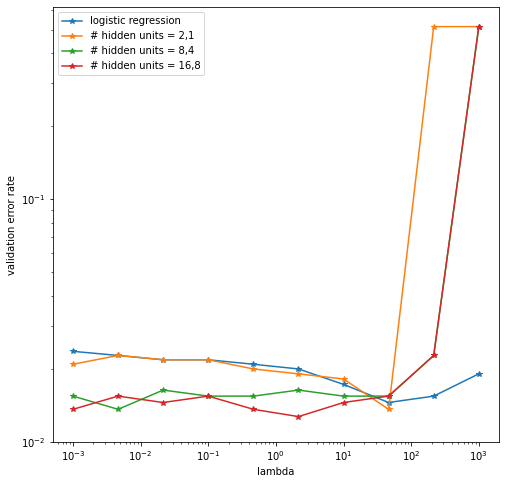

In [211]:
%%time
def errorrate(Y,predy):
    predy = np.sign(predy)
    return (predy!=Y).mean()
    
def multirestart(trainX,trainY,nhid,lam,ntries):
    besterrsc = 2.0
    for i in range(ntries):
        Wts = trainneuralnet(trainX,trainY,nhid,lam)
        errsc = errorrate(trainY,nneval(trainX,Wts))
        if errsc<besterrsc:
            returnWts = Wts
            besterrsc = errsc
    return returnWts
nhiddens = np.array([0,2,8,16])
lams = np.logspace(-3,3,10)
erates = np.empty([lams.shape[0],nhiddens.shape[0]])
erates[:,:] = np.nan
(f,ax) = setupfig()

for ni, nhid in enumerate(nhiddens):
    for li, lam in reversed(list(enumerate(lams))):
        if nhid==0:
            w = learnlogreg_sklearn(trainX,trainY,lam)
            predy = predictlogreg(validX,w)[:,np.newaxis]
        else:
            Wts = multirestart(trainX,trainY,nhid,lam,4)
            #Wts = trainneuralnet(trainX,trainY,nhid,lam)
            predy = nneval(validX,Wts)
        erates[li,ni] = errorrate(validY,predy)
        plotit(lams,nhiddens,erates,f,ax)

<div style="color: #000000;background-color: #FFFFEE">
    <font size=+2>Question 2:</font> <font size=+1>(3 points)</font>
How do you interpret the plot above?  How and why does the plot differ by number of hidden units?  By $\lambda$ value?  What parts of this plot agree with the material taught?  What parts do not?
</div>
<div class="alert alert-success">
    <font size=+1>Grading</font> (to be completed by grader)<br>
    Score: /3<br>
</div>

## Your answer here 
It is observable from the plot that as we increase the number of hidden units, we start getting lower error rates but as the value of lamda reaches to a large one (in this case 10^2) the error rate increases exponentially.
#Hidden Units (2,1) This neural network shows relatively higher validation error rates compared to the others, indicating that it may not capture the complexities of the dataset as effectively. and it exhibits smoother changes in error rates with varying lamda values.Hidden Units (8,4: The error rates for thi snetowrke are lower than those for the two hidden units, suggesting better model performance. The fluctuations in error rates are moed,which mean git is more sensitivey to changes in regularization strength.#n Hidden Units (16, T Ts hinetwor krsho es the lowest error rates among the teens, indicating superior model performan cebut, il shots more extreme fluctuations in error te.tThe plot doesnt agree with the statement made in chapter 6 ""Small values of the regurlarization strength) improvse the testing accurac 
when there are fewer features. Larger values for the regularizati n
strense) imprsove the testing accuracy when there
are more features, but make the testing accuracy worse when there
are fewer feat""
-det..-1.on